In [2]:
import uproot
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
plt.rcParams['figure.dpi'] = 400
plt.style.use('fivethirtyeight')

In [4]:
filename = '../../Geant4Model/build/Output/output0.root'
file = uproot.open(filename)

names = np.array(file.keys())
times = names[:len(names) // 3]
cover_hists = names[len(names) // 3::2]

In [4]:
digit_pattern = "-?\d+\.?\d*"

In [5]:
time_array = np.zeros((len(times), 4))

for i, time in enumerate(times):
    time_array[i] = file[time]['t_ns'].array(library='np')[1:5]

In [6]:
x = np.array([-21.29, -21.63, 17.5, 21.16])
y = np.array([21.68, -21.13, 9.34, -21.05])
z = 1700

c_norm = 0.3

x_sq = x**2
y_sq = y**2
xy = x*y

x_mean = x.mean()
y_mean = y.mean()
x_mean_sq = x_mean**2
y_mean_sq = y_mean**2
x_sq_mean = x_sq.mean()
y_sq_mean = y_sq.mean()
xy_mean = xy.mean()
xy_mean_sq = xy_mean**2

def get_PFA_theta(t):
    
    t_mean = t.mean()
    xt_mean = (x*t).mean()
    yt_mean = (y*t).mean()

    xt_dif = xt_mean - x_mean*t_mean
    x2t_dif = x_sq_mean*t_mean - x_mean*xt_mean
    x2x_dif = x_mean_sq - x_sq_mean

    yt_dif = yt_mean - y_mean*t_mean
    y2t_dif = y_sq_mean*t_mean - y_mean*yt_mean
    y2y_dif = y_mean_sq - y_sq_mean

    nx = (xy_mean*yt_dif+x_mean*y2t_dif+xt_mean*y2y_dif)/(x_sq_mean*y_mean_sq+x_mean_sq*y_sq_mean-2*x_mean*y_mean*xy_mean+xy_mean_sq-x_sq_mean*y_sq_mean)*c_norm
    ny = (xy_mean*xt_dif+y_mean*x2t_dif+yt_mean*x2x_dif)/(x_sq_mean*y_mean_sq+x_mean_sq*y_sq_mean-2*x_mean*y_mean*xy_mean+xy_mean_sq-x_sq_mean*y_sq_mean)*c_norm

    nz = np.sqrt(1-nx**2-ny**2)

    theta = np.arccos(nz)
    
    if np.isnan(theta):
        return (-1, -1, -1, -1)
    else:
        return (np.degrees(theta), nx, ny, nz)

# PFAWTC

In [7]:
x_EAS = []
y_EAS = []

for hist_name in cover_hists:
    x_EAS.append(re.findall(digit_pattern, hist_name)[3])
    y_EAS.append(re.findall(digit_pattern, hist_name)[4])

In [8]:
def constr(pars):
    nx, ny, nz, t0 = pars

    return nx**2+ny**2+nz**2-1

In [9]:
sigma_to = 2.6
b = 1.5
r_t = 30

def Chi_sq(params, x0, y0, t):
    
    nx, ny, nz, t0 = params

    chi_sq = 0

    n = len(t)
    
    for i in range(n):
        r_i = np.sqrt((x[i]-x0)**2+(y[i]-y0)**2)
        sigma_i = sigma_to*(1+r_i/r_t)**b
        w_i = 1/(sigma_i**2)

        chi_sq += w_i*(nx*x[i]+ny*y[i]*nz*z-c_norm*(t[i]-t0))**2
        
    return chi_sq

In [10]:
constraint = {'type': 'eq', 'fun': constr}

def get_PFAWTC_theta(t, x0, y0):

    PFA_result = get_PFA_theta(t)

    if (PFA_result == (-1, -1, -1, -1)):
        return

    initial_guess = np.append(get_PFA_theta(t)[1:], t.min())

    result = minimize(Chi_sq, initial_guess, args=(float(x0), float(y0), t), constraints=constraint, tol=1e-6)

    return result

In [11]:
PFAWTC_angles = []

for i, time_arr in enumerate(time_array):
    if np.all(time_arr):
        result = get_PFAWTC_theta(time_arr, x_EAS[i], y_EAS[i])
        
        if result:
            if result.success:
                fitted_params = result.x
                #print(fitted_params[0]**2+fitted_params[1]**2+fitted_params[2]**2)
                theta = np.degrees(np.arccos(fitted_params[2]))
                PFAWTC_angles.append(theta)
            else:
                raise ValueError(result.message)

In [12]:
PFAWTC_angles = np.array(PFAWTC_angles)
np.median(PFAWTC_angles)

8.604703280743637

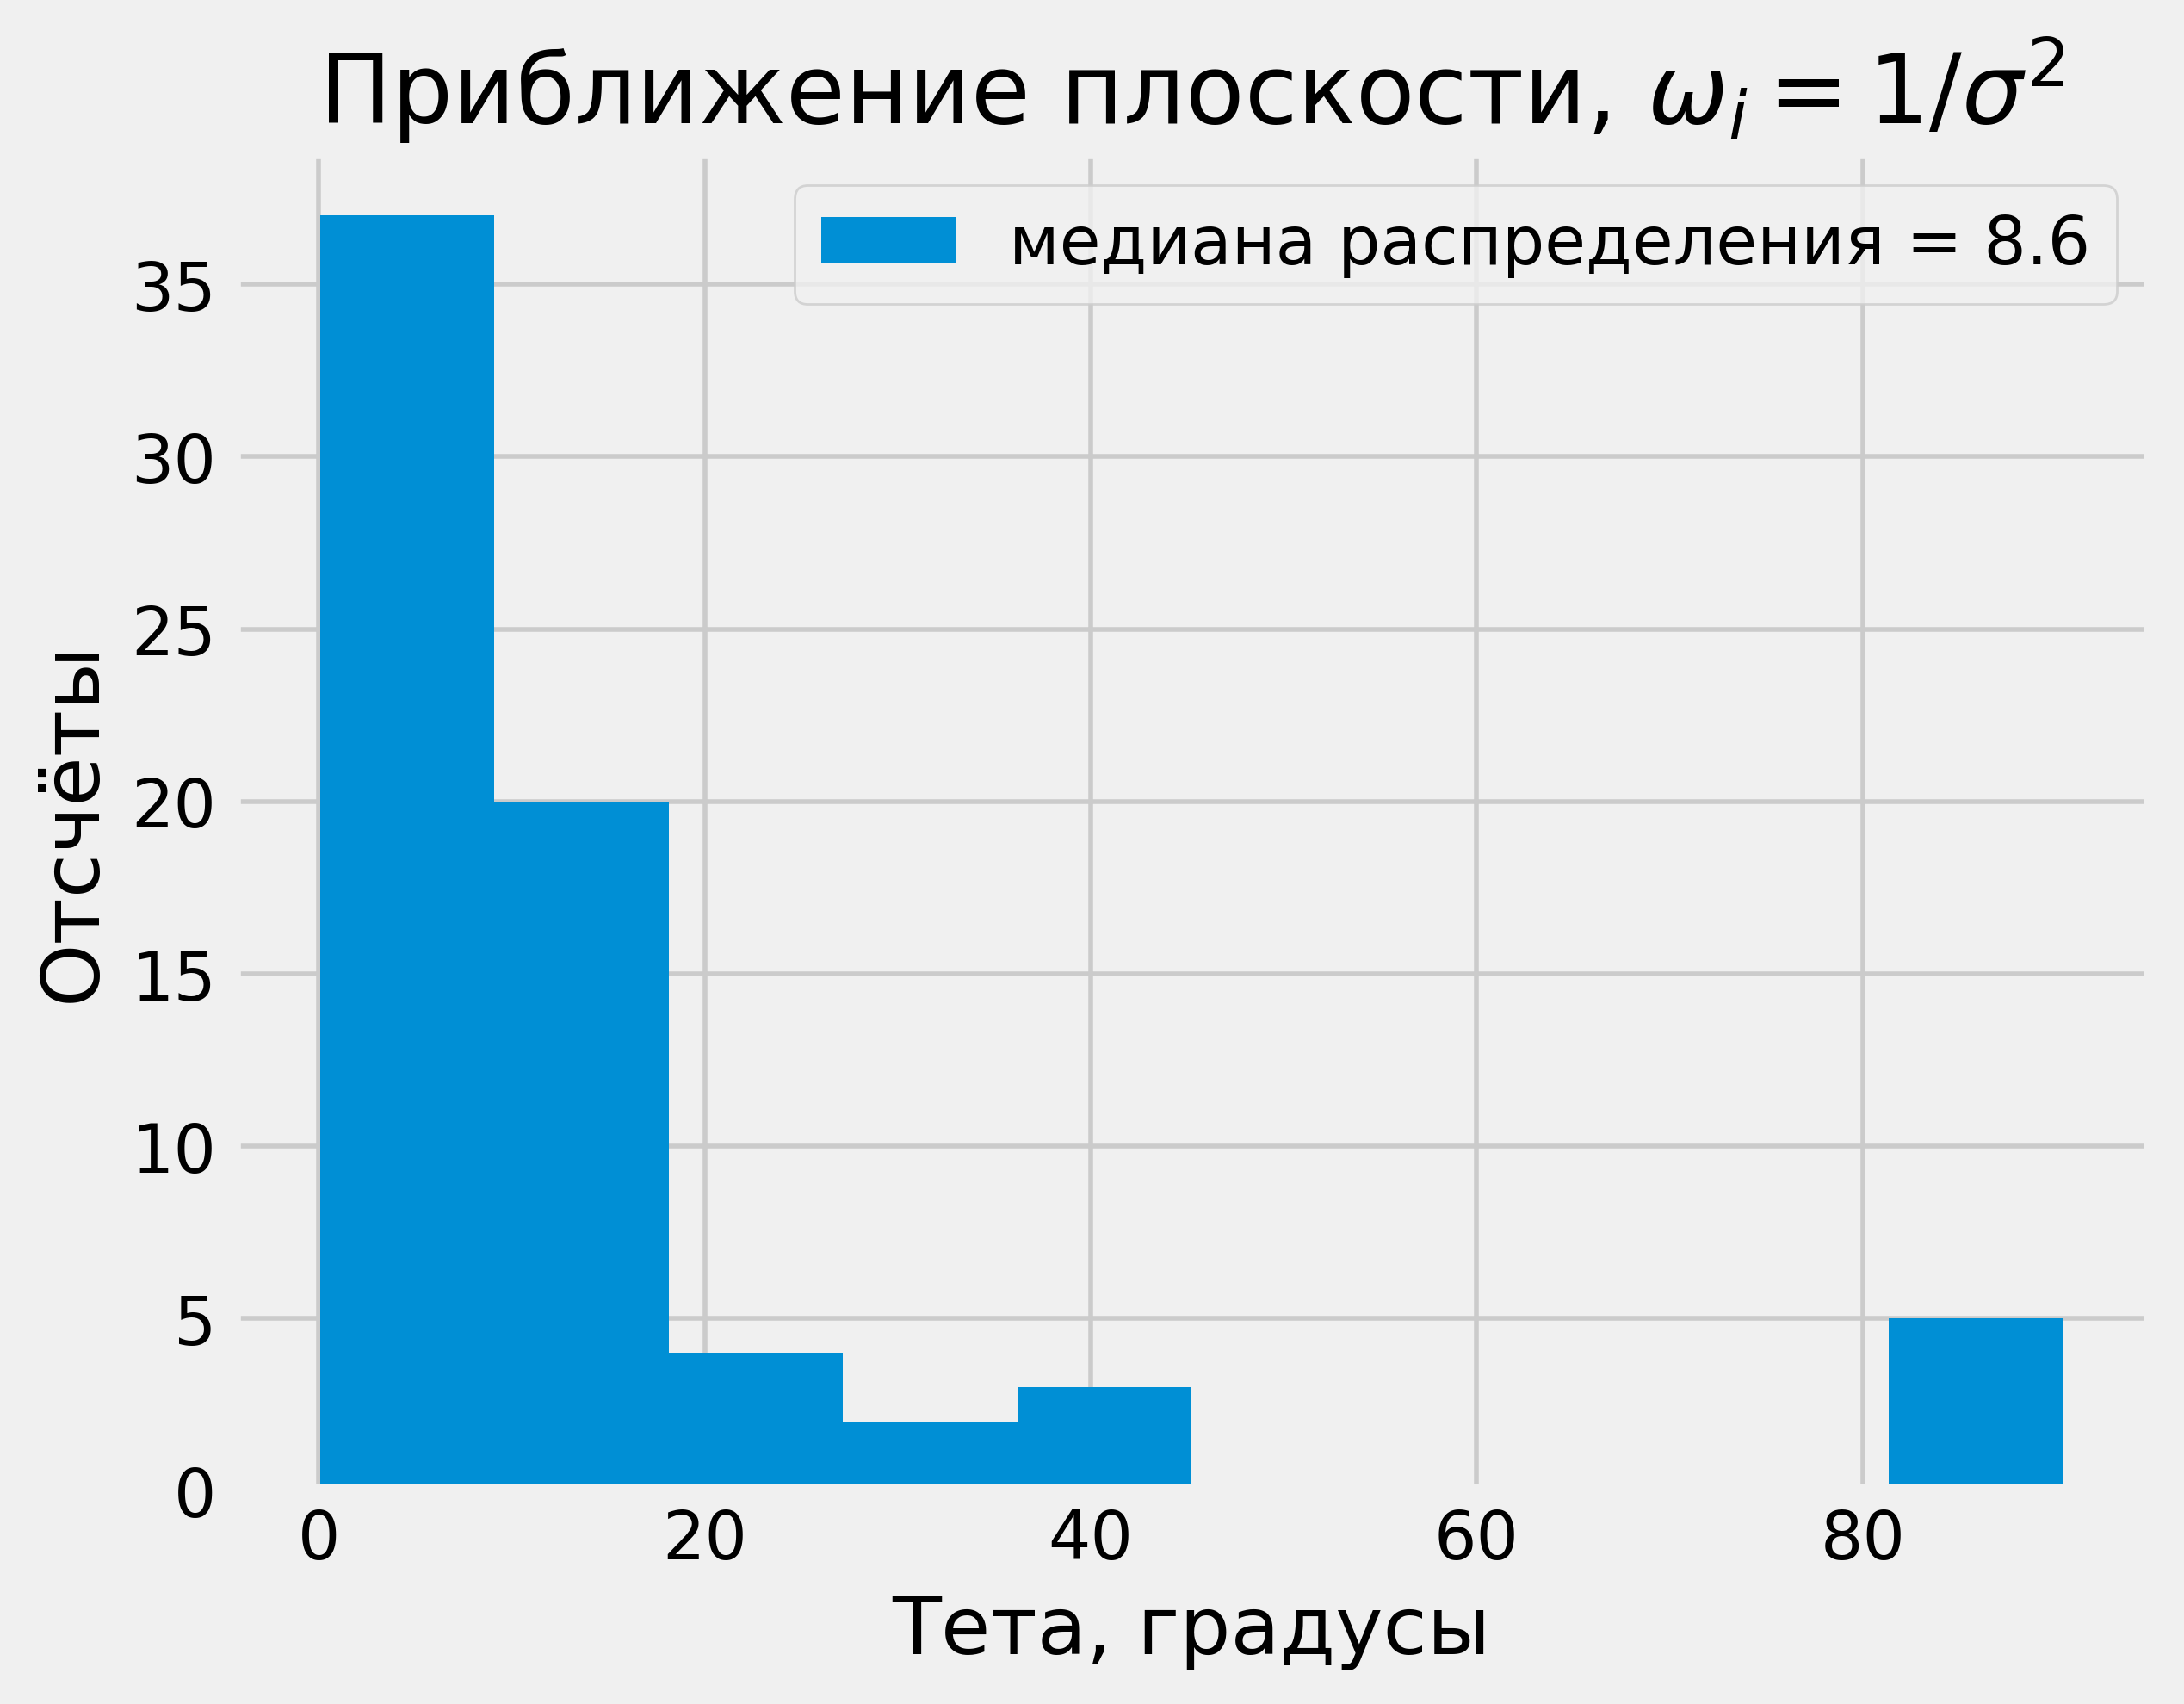

In [13]:
plt.hist(PFAWTC_angles, label='медиана распределения = '+str(round(np.median(PFAWTC_angles), 2)))

plt.title('Приближение плоскости, $\omega_i = 1/\sigma^2$')

plt.xlabel('Тета, градусы')
plt.ylabel('Отсчёты')

plt.legend(loc='upper right')

plt.savefig('PFAWTC.png')